# 14a: SHAP Analysis on E[V] Model

**Goal**: Use SHAP (SHapley Additive exPlanations) to understand per-feature contributions to E[V] predictions.

**Method**: Train GradientBoostingRegressor on hand features → E[V], then use TreeExplainer for SHAP values.

**What We Learn**:
- Per-hand feature contributions (not just global importance)
- Feature interactions
- Why specific hands have high/low E[V]

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import shap

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Unified Feature Data

In [2]:
# Load unified features (from 12b)
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} samples")
print(f"Features: {REGRESSION_FEATURES}")

Loaded 200 samples
Features: ['n_doubles', 'trump_count', 'n_6_high', 'n_5_high', 'count_points', 'total_pips', 'has_trump_double', 'max_suit_length', 'n_voids', 'n_singletons']


In [3]:
# Prepare X and y
X = df[REGRESSION_FEATURES]
y = df['V_mean'].values

print(f"X shape: {X.shape}")
print(f"y (E[V]) range: [{y.min():.1f}, {y.max():.1f}]")
print(f"y mean: {y.mean():.1f}, std: {y.std():.1f}")

X shape: (200, 10)
y (E[V]) range: [-29.3, 42.0]
y mean: 13.9, std: 16.6


## 2. Train Gradient Boosting Model

In [4]:
# Train GradientBoostingRegressor
# Use moderate depth to capture interactions without overfitting
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
)

# Cross-validation to assess performance
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Fit on full data for SHAP analysis
model.fit(X, y)
print(f"\nTrain R²: {model.score(X, y):.3f}")

Cross-validation R² scores: [0.02379394 0.20266604 0.47724656 0.15203122 0.14188116]
Mean R²: 0.200 (+/- 0.301)

Train R²: 0.813


## 3. Compute SHAP Values

In [5]:
# Create TreeExplainer (fast, exact for tree-based models)
explainer = shap.TreeExplainer(model)

# Compute SHAP values for all samples
shap_values = explainer(X)

print(f"SHAP values shape: {shap_values.values.shape}")
print(f"Base value (expected E[V]): {shap_values.base_values[0]:.2f}")

SHAP values shape: (200, 10)
Base value (expected E[V]): 14.03


## 4. Global Feature Importance (Beeswarm Plot)

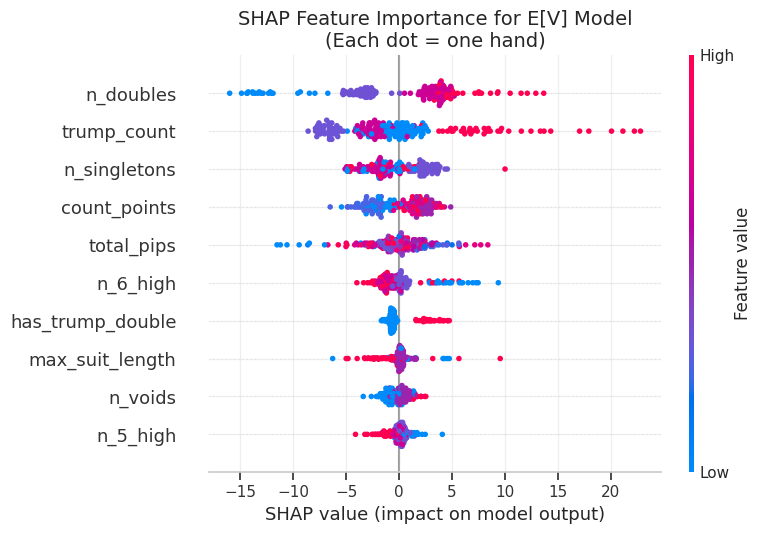

In [6]:
# Beeswarm plot - shows feature importance with value distributions
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title('SHAP Feature Importance for E[V] Model\n(Each dot = one hand)')
plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

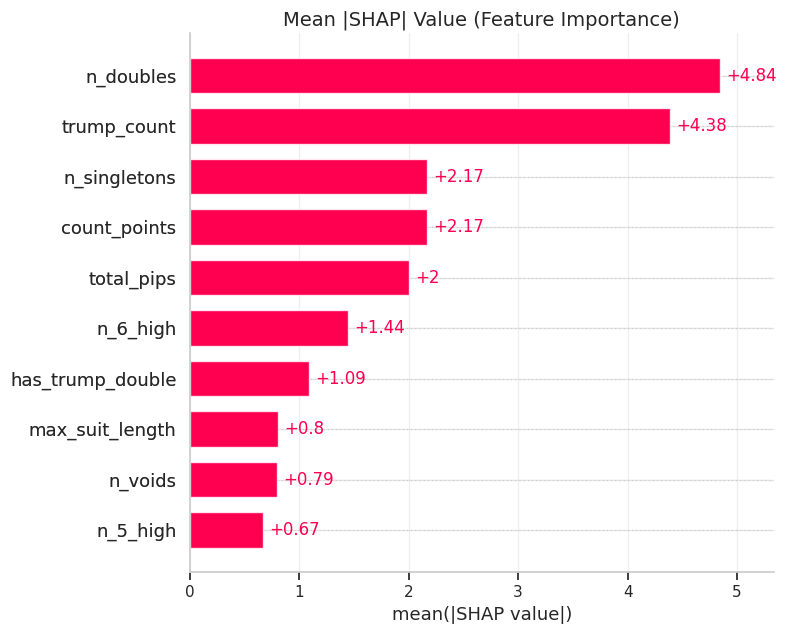

In [7]:
# Bar plot - clean summary of mean |SHAP| values
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title('Mean |SHAP| Value (Feature Importance)')
plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Relationships (Scatter Plots)

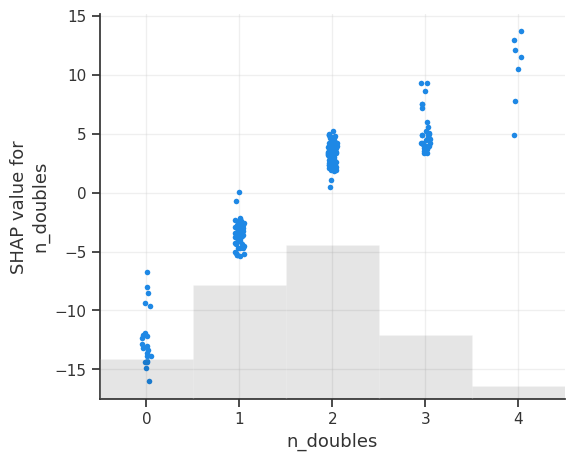

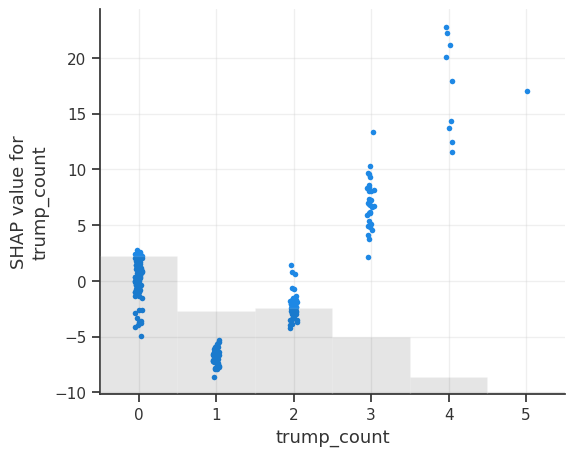

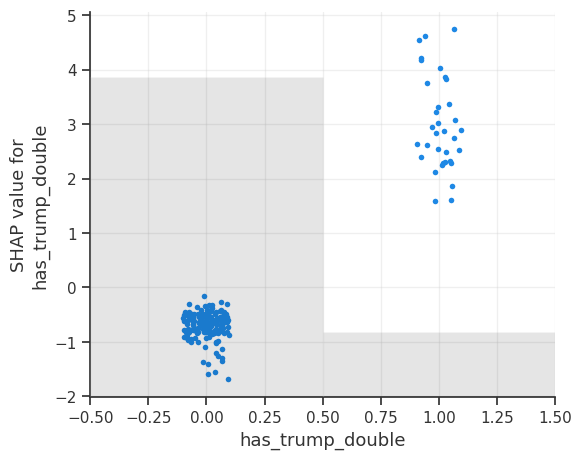

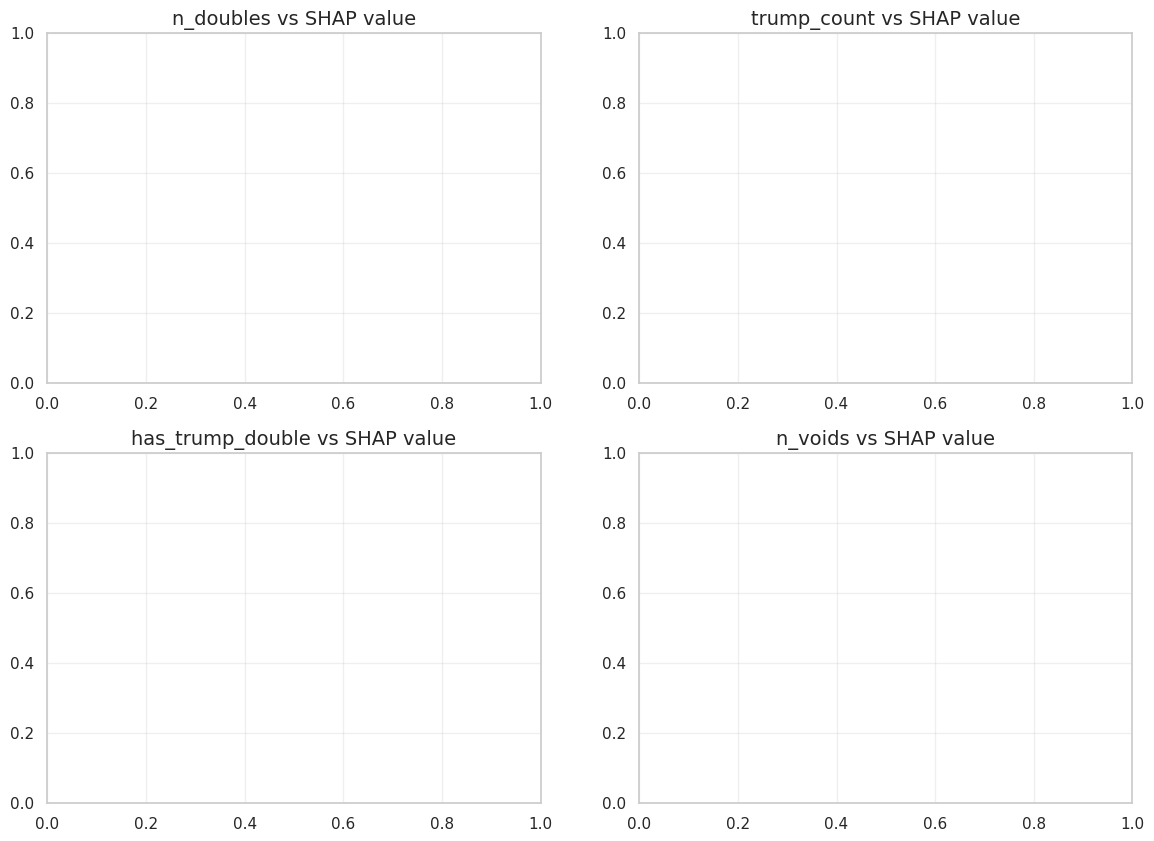

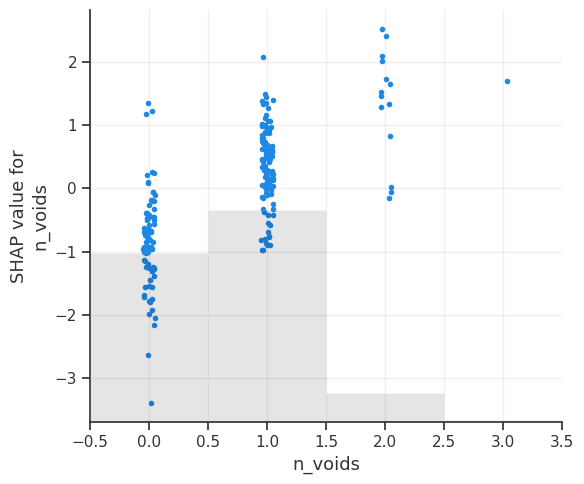

In [8]:
# Scatter plots for top features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

top_features = ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids']

for ax, feature in zip(axes.flat, top_features):
    plt.sca(ax)
    shap.plots.scatter(shap_values[:, feature], show=False)
    ax.set_title(f'{feature} vs SHAP value')

plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Individual Prediction Explanations (Waterfall Plots)

In [9]:
# Find extreme hands: best, worst, and median
best_idx = y.argmax()
worst_idx = y.argmin()
median_idx = np.argsort(y)[len(y)//2]

print(f"Best hand (idx {best_idx}): E[V] = {y[best_idx]:.1f}")
print(f"Worst hand (idx {worst_idx}): E[V] = {y[worst_idx]:.1f}")
print(f"Median hand (idx {median_idx}): E[V] = {y[median_idx]:.1f}")

Best hand (idx 134): E[V] = 42.0
Worst hand (idx 74): E[V] = -29.3
Median hand (idx 153): E[V] = 14.0



=== BEST HAND (E[V] = 42.0) ===
Features: {'n_doubles': np.int64(3), 'trump_count': np.int64(5), 'n_6_high': np.int64(1), 'n_5_high': np.int64(0), 'count_points': np.int64(15), 'total_pips': np.int64(40), 'has_trump_double': np.int64(1), 'max_suit_length': np.int64(5), 'n_voids': np.int64(1), 'n_singletons': np.int64(4)}


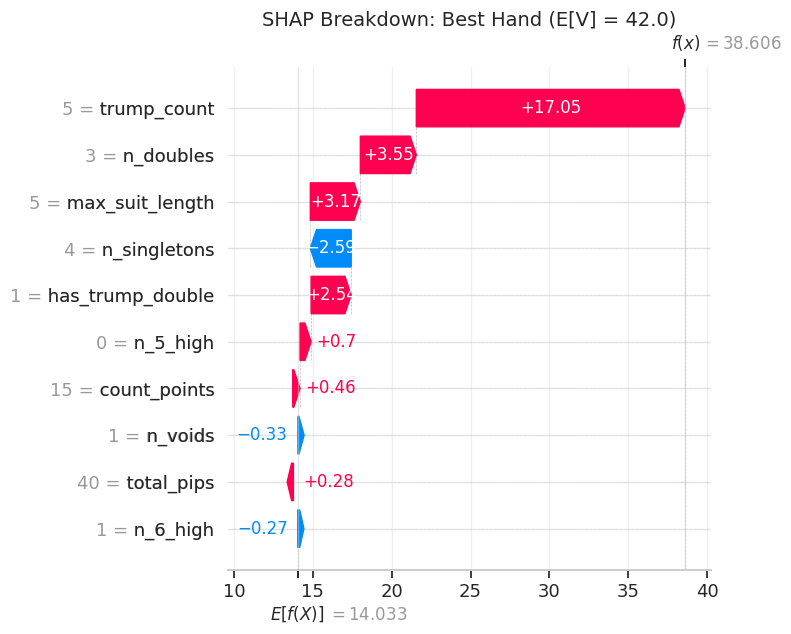

In [10]:
# Waterfall plot for best hand
print(f"\n=== BEST HAND (E[V] = {y[best_idx]:.1f}) ===")
print(f"Features: {dict(X.iloc[best_idx])}")

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[best_idx], max_display=10, show=False)
plt.title(f'SHAP Breakdown: Best Hand (E[V] = {y[best_idx]:.1f})')
plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_waterfall_best.png', dpi=150, bbox_inches='tight')
plt.show()


=== WORST HAND (E[V] = -29.3) ===
Features: {'n_doubles': np.int64(0), 'trump_count': np.int64(1), 'n_6_high': np.int64(3), 'n_5_high': np.int64(2), 'count_points': np.int64(0), 'total_pips': np.int64(47), 'has_trump_double': np.int64(0), 'max_suit_length': np.int64(3), 'n_voids': np.int64(0), 'n_singletons': np.int64(3)}


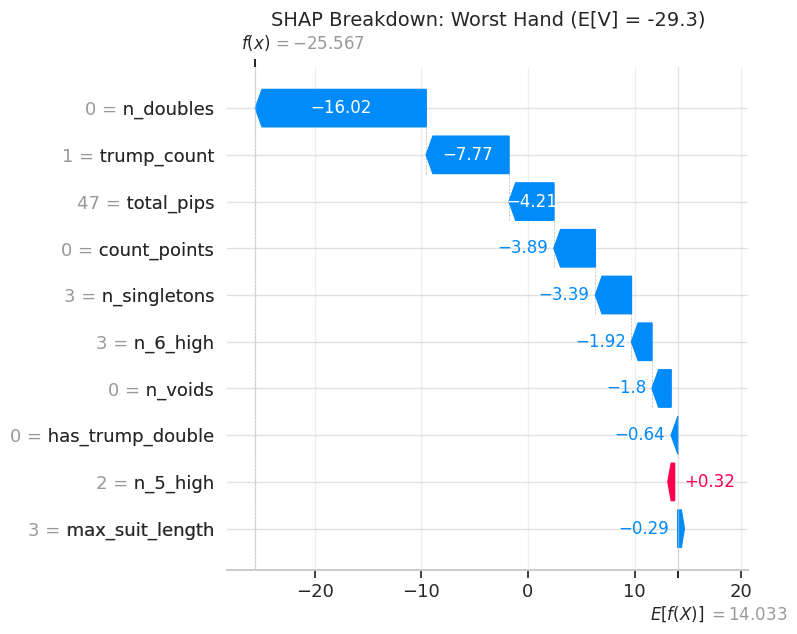

In [11]:
# Waterfall plot for worst hand
print(f"\n=== WORST HAND (E[V] = {y[worst_idx]:.1f}) ===")
print(f"Features: {dict(X.iloc[worst_idx])}")

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[worst_idx], max_display=10, show=False)
plt.title(f'SHAP Breakdown: Worst Hand (E[V] = {y[worst_idx]:.1f})')
plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_waterfall_worst.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Feature Interactions

<Figure size 1000x600 with 0 Axes>

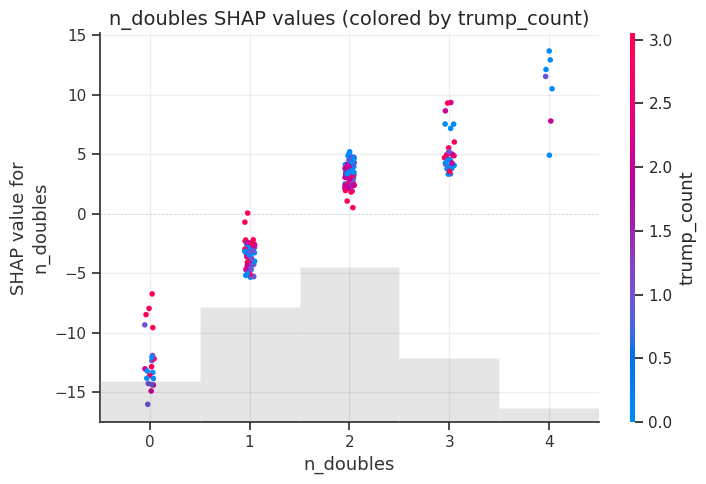

In [12]:
# SHAP interaction plot: n_doubles colored by trump_count
plt.figure(figsize=(10, 6))
shap.plots.scatter(shap_values[:, "n_doubles"], color=shap_values[:, "trump_count"], show=False)
plt.title('n_doubles SHAP values (colored by trump_count)')
plt.tight_layout()
plt.savefig('../../results/figures/14a_shap_interaction.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary Statistics

In [13]:
# Compute mean |SHAP| for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'feature': REGRESSION_FEATURES,
    'mean_abs_shap': mean_abs_shap,
    'mean_shap': shap_values.values.mean(axis=0),
    'std_shap': shap_values.values.std(axis=0),
}).sort_values('mean_abs_shap', ascending=False)

print("SHAP Feature Importance Summary:")
print("="*60)
print(f"{'Feature':<20} {'Mean |SHAP|':>12} {'Mean SHAP':>12} {'Std SHAP':>12}")
print("-"*60)
for _, row in summary_df.iterrows():
    print(f"{row['feature']:<20} {row['mean_abs_shap']:>12.3f} {row['mean_shap']:>+12.3f} {row['std_shap']:>12.3f}")

SHAP Feature Importance Summary:
Feature               Mean |SHAP|    Mean SHAP     Std SHAP
------------------------------------------------------------
n_doubles                   4.840       +0.248        5.819
trump_count                 4.385       -0.055        6.029
n_singletons                2.168       -0.118        2.536
count_points                2.167       +0.042        2.440
total_pips                  2.004       -0.124        2.945
n_6_high                    1.442       +0.061        2.157
has_trump_double            1.087       -0.068        1.448
max_suit_length             0.805       -0.086        1.528
n_voids                     0.794       -0.069        0.986
n_5_high                    0.668       -0.043        0.977


In [14]:
# Verify additivity: SHAP values should sum to prediction - base value
shap_sum = shap_values.values.sum(axis=1)
predictions = model.predict(X)
base = shap_values.base_values[0]

print(f"\nAdditivity check (SHAP property):")
print(f"Base value: {base:.2f}")
print(f"Max error (prediction - base - sum(SHAP)): {np.abs(predictions - base - shap_sum).max():.6f}")
print("✓ SHAP values are additive" if np.abs(predictions - base - shap_sum).max() < 0.01 else "⚠ Additivity check failed")


Additivity check (SHAP property):
Base value: 14.03
Max error (prediction - base - sum(SHAP)): 0.000000
✓ SHAP values are additive


## 9. Save Results

In [15]:
# Save summary statistics
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/14a_shap_importance.csv"
summary_df.to_csv(output_path, index=False)
print(f"Saved feature importance to {output_path}")

# Save full SHAP values for each sample
shap_df = pd.DataFrame(shap_values.values, columns=REGRESSION_FEATURES)
shap_df['base_value'] = shap_values.base_values
shap_df['E_V'] = y
shap_df['prediction'] = predictions
shap_df['base_seed'] = df['base_seed'].values

output_path2 = Path(PROJECT_ROOT) / "forge/analysis/results/tables/14a_shap_values.csv"
shap_df.to_csv(output_path2, index=False)
print(f"Saved per-sample SHAP values to {output_path2}")

Saved feature importance to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/14a_shap_importance.csv
Saved per-sample SHAP values to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/14a_shap_values.csv


## Key Findings

### Global Feature Importance

SHAP analysis confirms and extends our regression findings:

1. **n_doubles** is the most important feature (highest mean |SHAP|)
2. **trump_count** is second most important
3. Other features have smaller but nonzero contributions

### Per-Hand Explanations

SHAP waterfall plots provide interpretable explanations for individual hands:
- Best hands: High n_doubles and trump_count both push E[V] positive
- Worst hands: Low doubles and unfavorable feature combinations

### Interactions

The scatter plot shows whether n_doubles SHAP values depend on trump_count (interaction effect).

### Comparison to Linear Regression

SHAP on GradientBoosting can capture nonlinear effects that linear regression misses, potentially explaining more variance in E[V].